In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_dir = "../data"

In [67]:
dfs = [
    (
        "Llama 2 7B 4bit vript",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1819_llama-2-7b_4bit_rephrase_vript.pkl"),
    ),
    (
        "Llama 2 7B 4bit finenews",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1820_llama-2-7b_4bit_rephrase_finenews.pkl"),
    ),
]

In [68]:
llama_language_percentages = {
    "en": 0.897,
    "de": 0.17,
    "es": 0.13,
    "fr": 0.16,
    "it": 0.11,
    "ko": 0.06,
    "pt": 0.09,
    "ru": 0.13,
    "zh": 0.13,
}

In [69]:
def normalized_rephrases_gradients(row):
    grads = row["rephrased_gradients"]
    rephrase_lengths = row["rephrased_prompt_lengths"]
    return [g / l if l else 0 for g, l in zip(grads, rephrase_lengths)]


for _, df in dfs:
    df["language_share"] = df["language"].map(llama_language_percentages)

    df["prompt_gradient_normalized"] = df.apply(
        lambda row: (
            row["prompt_gradient"] / row["prompt_length"]
            if row["prompt_length"] > 0
            else 0
        ),
        axis=1,
    )
    df["rephrased_gradient_mean"] = df["rephrased_gradients"].apply(
        lambda x: np.mean(x)
    )

    df["rephrased_gradient_normalized_mean"] = df.apply(
        lambda row: np.mean(normalized_rephrases_gradients(row)), axis=1
    )

    df["log_prompt_gradient"] = df["prompt_gradient"].apply(
        lambda x: np.log(x) if x > 0 else 0
    )
    df["log_rephrased_gradient_mean"] = df["rephrased_gradient_mean"].apply(
        lambda x: np.log(x) if x > 0 else 0
    )
    df["log_rephrased_gradient_std"] = df["rephrased_gradient_std"].apply(
        lambda x: np.log(x) if x > 0 else 0
    )

    bins = 25


    df["prompt_gradient"] = df["prompt_gradient"].replace(
        [np.inf, -np.inf], np.nan
    )
    df["prompt_gradient_bins"] = pd.cut(
        df["prompt_gradient"], bins=bins, labels=False
    )

    df["rephrased_gradient_mean"] = df["rephrased_gradient_mean"].replace(
        [np.inf, -np.inf], np.nan
    )
    df["rephrased_gradient_mean_bins"] = pd.cut(
        df["rephrased_gradient_mean"], bins=bins, labels=False
    )

    df["rephrased_gradient_std"] = df["rephrased_gradient_std"].replace(
        [np.inf, -np.inf], np.nan
    )
    df["rephrased_gradient_std_bins"] = pd.cut(
        df["rephrased_gradient_std"], bins=bins, labels=False
    )

    df["prompt_gradient_normalized"] = df["prompt_gradient_normalized"].replace(
        [np.inf, -np.inf], np.nan
    )
    df["prompt_gradient_normalized_bins"] = pd.cut(
        df["prompt_gradient_normalized"], bins=bins, labels=False
    )

    df["rephrased_gradient_normalized_mean"] = df["rephrased_gradient_normalized_mean"].replace(
        [np.inf, -np.inf], np.nan
    )
    df["rephrased_gradient_normalized_mean_bins"] = pd.cut(
        df["rephrased_gradient_normalized_mean"], bins=bins, labels=False
    )

    df["log_prompt_gradient"] = df["log_prompt_gradient"].replace(
        [np.inf, -np.inf], np.nan
    )
    df["log_prompt_gradient_bins"] = pd.cut(
        df["log_prompt_gradient"], bins=bins, labels=False
    )

    df["log_rephrased_gradient_mean"] = df["log_rephrased_gradient_mean"].replace(
        [np.inf, -np.inf], np.nan
    )
    df["log_rephrased_gradient_mean_bins"] = pd.cut(
        df["log_rephrased_gradient_mean"], bins=bins, labels=False
    )

    df["log_rephrased_gradient_std"] = df["log_rephrased_gradient_std"].replace(
        [np.inf, -np.inf], np.nan
    )
    df["log_rephrased_gradient_std_bins"] = pd.cut(
        df["log_rephrased_gradient_std"], bins=bins, labels=False
    )

In [70]:
dfs[0][1]

,prompt,prompt_length,language,prompt_gradient,rephrased_prompts,rephrased_prompt_lengths,rephrased_gradients,rephrased_gradient_std,language_share,prompt_gradient_normalized,...,log_rephrased_gradient_mean,log_rephrased_gradient_std,prompt_gradient_bins,rephrased_gradient_mean_bins,rephrased_gradient_std_bins,prompt_gradient_normalized_bins,rephrased_gradient_normalized_mean_bins,log_prompt_gradient_bins,log_rephrased_gradient_mean_bins,log_rephrased_gradient_std_bins
0,The video appears to be an animated scene feat...,269,en,6.520752,[The animation showcases two sheep-like charac...,"[257, 248, 255]","[6.167607307434082, 6.430628776550293, 6.57685...",0.207384,0.897,0.024241,...,1.855000,-1.573181,12,3,0,15,0,17,15,9
1,The video features an animated character resem...,257,en,6.307759,[The clip showcases an animated sheep-like cha...,"[257, 250, 240]","[6.607749938964844, 6.3016252517700195, 7.0401...",0.371050,0.897,0.024544,...,1.894592,-0.991418,11,3,0,16,0,16,15,11
2,The video features a graphic animation style p...,303,en,6.154725,[The video showcases a graphic animation style...,"[299, 286, 308]","[5.909190654754639, 6.23834228515625, 5.764328...",0.242905,0.897,0.020313,...,1.786851,-1.415087,11,2,0,13,0,16,14,10
3,"The video depicts a single character, an anthr...",227,en,6.468607,"[The video features a lone character, a cartoo...","[226, 225, 216]","[6.356639385223389, 6.404195308685303, 6.34835...",0.030133,0.897,0.028496,...,1.851557,-3.502123,12,3,0,19,0,16,15,4
4,The video features an animated character with ...,291,en,6.105120,[The clip showcases an animated figure display...,"[262, 275, 280]","[6.149026393890381, 5.717566013336182, 6.04374...",0.224957,0.897,0.020980,...,1.786766,-1.491846,11,2,0,13,0,15,14,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,这段视频发生在一个停车场或类似的室外环境中。视频主要展示了一辆白色轿车停在带有黄色标线的坡道...,401,zh,4.533913,[.这段视频拍摄于一个停车场或类似的户外场地，主要呈现了一辆白色轿车停在黄色标线的坡道上。这...,"[371, 396, 2472]","[4.783549785614014, 4.56787633895874, 1.541036...",1.813016,0.130,0.011307,...,1.289459,0.594992,6,1,0,6,0,11,12,15
835,视频展示了一辆白色轿车停在坡道上，环境是户外停车场，地面有轮胎留下的痕迹和黄色的标线。视频中...,442,zh,4.322781,[视频显示了一辆白色轿车停靠在一个坡道上，所处环境是一个户外停车场，地面有轮胎印和黄色标线。...,"[435, 442, 451]","[4.6316304206848145, 5.4932861328125, 4.604571...",0.505469,0.130,0.009780,...,1.591239,-0.682268,6,2,0,5,0,10,13,12
836,视频中展示的是一辆停靠在路边的白色轿车，环境看似为户外的停车场或类似区域，天气似乎是阴天或是...,421,zh,4.497557,[视频展示了一辆白色轿车停靠在路边，周围环境像是一个户外停车场，天气阴沉或临近黄昏，光线较弱...,"[380, 370, 382]","[4.451821804046631, 4.607692241668701, 4.50618...",0.079114,0.130,0.010683,...,1.508932,-2.536863,6,2,0,5,0,11,13,7
837,视频展示了一辆停在路边的白色轿车的侧面，然后镜头逐渐向车窗移动。通过逐渐清晰的画面，我们可以...,373,zh,4.659462,[视频开始时展示了一辆白色轿车停在路边的侧影，随后镜头慢慢移动到车窗上。从渐渐清晰的影像中，...,"[355, 365, 360]","[4.803847789764404, 4.606786727905273, 4.99665...",0.194937,0.130,0.012492,...,1.569122,-1.635079,7,2,0,7,0,11,13,9


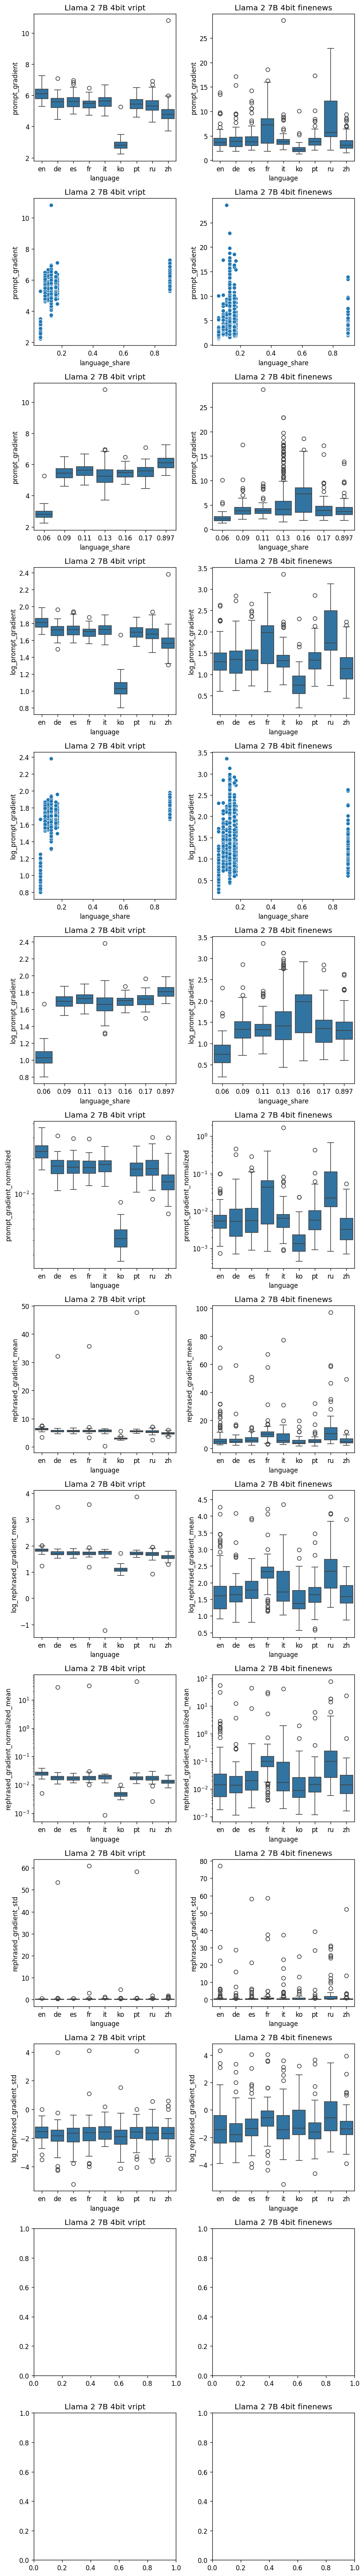

In [71]:
plt.rcParams["figure.dpi"] = 120
plot_size = 4

plt_width = len(dfs)
plt_height = 14

fig, axs = plt.subplots(
    plt_height,
    plt_width,
    figsize=(plt_width * plot_size, plt_height * plot_size),
    squeeze=False,
)

for i, (name, df) in enumerate(dfs):
    j = 0

    sns.boxplot(data=df, x="language", y="prompt_gradient", ax=axs[j][i])
    j += 1

    sns.scatterplot(data=df, x="language_share", y="prompt_gradient", ax=axs[j][i])
    j += 1

    sns.boxplot(data=df, x="language_share", y="prompt_gradient", ax=axs[j][i])
    j += 1

    sns.boxplot(data=df, x="language", y="log_prompt_gradient", ax=axs[j][i])
    j += 1

    sns.scatterplot(data=df, x="language_share", y="log_prompt_gradient", ax=axs[j][i])
    j += 1

    sns.boxplot(data=df, x="language_share", y="log_prompt_gradient", ax=axs[j][i])
    j += 1

    sns.boxplot(
        data=df,
        x="language",
        y="prompt_gradient_normalized",
        ax=axs[j][i],
        log_scale=True,
    )
    j += 1

    sns.boxplot(data=df, x="language", y="rephrased_gradient_mean", ax=axs[j][i])
    j += 1

    sns.boxplot(data=df, x="language", y="log_rephrased_gradient_mean", ax=axs[j][i])
    j += 1

    sns.boxplot(
        data=df,
        x="language",
        y="rephrased_gradient_normalized_mean",
        ax=axs[j][i],
        log_scale=True,
    )
    j += 1

    sns.boxplot(data=df, x="language", y="rephrased_gradient_std", ax=axs[j][i])
    j += 1

    sns.boxplot(data=df, x="language", y="log_rephrased_gradient_std", ax=axs[j][i])
    j += 1

    # sns.violinplot(data=df, x="language", y="prompt_gradient", ax=axs[j][i])
    # j += 1

    # sns.violinplot(data=df, x="language", y="rephrased_gradient_mean", ax=axs[j][i])
    # j += 1

    # sns.violinplot(data=df, x="language", y="rephrased_gradient_std", ax=axs[j][i])
    # j += 1

    # sns.violinplot(
    #     data=df, x="language", y="prompt_gradient_normalized", ax=axs[j][i]
    # )
    # j += 1

    # sns.violinplot(
    #     data=df, x="language", y="rephrased_gradient_normalized_mean", ax=axs[j][i]
    # )
    # j += 1

    for ax in axs.T[i]:
        ax.set_title(name)


plt.tight_layout()

In [72]:
for name, df in dfs:
    true_gradients = df[df["language"] == True]["prompt_gradient"]
    false_gradients = df[df["language"] == False]["prompt_gradient"]

    t_stat, p_value = ttest_ind(true_gradients, false_gradients, equal_var=False)

    print(f"{name:<30} T-statistic: {t_stat:>12.4f}, P-value: {p_value}")

Llama 2 7B 4bit vript          T-statistic:          nan, P-value: nan
Llama 2 7B 4bit finenews       T-statistic:          nan, P-value: nan


/Users/nilsgrunefeld/Documents/GitHub/gradient-uncertainty/env/lib/python3.13/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [73]:
for name, df in dfs:
    true_gradients = df[df["language"] == True]["prompt_gradient_normalized"]
    false_gradients = df[df["language"] == False]["prompt_gradient_normalized"]

    t_stat, p_value = ttest_ind(true_gradients, false_gradients, equal_var=False)

    print(f"{name:<30} T-statistic: {t_stat:>12.4f}, P-value: {p_value}")

Llama 2 7B 4bit vript          T-statistic:          nan, P-value: nan
Llama 2 7B 4bit finenews       T-statistic:          nan, P-value: nan
